# Lensing analysis tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# We use some stuff we learned before
from cmb_modules import calculate_2d_spectrum,make_CMB_T_map
np.random.seed(100)

## Simulating a lensed map

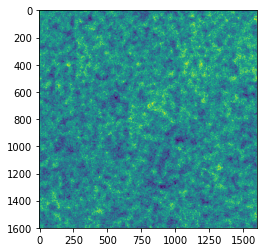

In [2]:

patch_deg_width = 40. # patch width in degrees
pix_size = 1.5 # pixel size in arcminutes

# Number of pixels in each direction
N = int(patch_deg_width*60./pix_size)

# We need to load the theory spectra
def get_theory():
    ells,tt,_,_,pp,_ = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat",unpack=True)
    TCMB2 = 7.4311e12
    ckk = pp/4./TCMB2
    ucltt = tt / ells/(ells+1.)*2.*np.pi
    ells2,lcltt = np.loadtxt("CMB_fiducial_totalCls.dat",unpack=True,usecols=[0,1])
    lcltt = lcltt / ells2/(ells2+1.)*2.*np.pi
    lcltt = lcltt[:len(ells)]
    return ells,ucltt,lcltt,ckk


ells,ucltt,lcltt,clkk = get_theory()

# We next generate an unlensed CMB map as a Gaussian random field as we learned before
DlTT = ucltt*ells*(ells+1.)/2./np.pi
unlensed = make_CMB_T_map(N,pix_size,ells,DlTT)
plt.imshow(unlensed)    
plt.show()


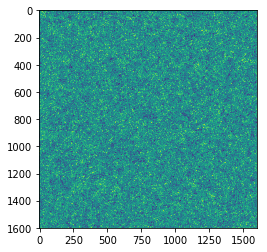

In [3]:
# We also need a lensing convergence (kappa) map
DlKK = clkk*ells*(ells+1.)/2./np.pi
kappa = make_CMB_T_map(N,pix_size,ells,DlKK)
plt.imshow(kappa)
plt.show()

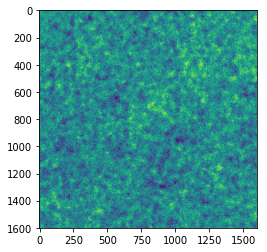

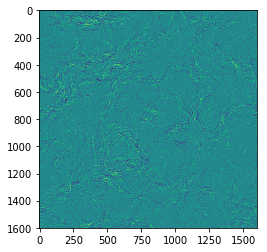

In [4]:
def lens_map(imap,kappa,modlmap,ly,lx,N,pix_size):
    # First we convert lensing convergence to lensing potential
    phi = kappa_to_phi(kappa,modlmap,return_fphi=True)
    # Then we take its gradient to get the deflection field
    grad_phi = gradient(phi,ly,lx)
    # Then we calculate the displaced positions by shifting the physical positions by the deflections
    pos = posmap(N,pix_size) + grad_phi
    # We convert the displaced positions into fractional displaced pixel numbers
    # because scipy doesn't know about physical distances
    pix = sky2pix(pos, N,pix_size)
    # We prepare an empty output lensed map array
    omap = np.empty(imap.shape, dtype= imap.dtype)
    # We then tell scipy to calculate the values of the input lensed map
    # at the displaced fractional positions by interpolation and grid that onto the final lensed map
    from scipy.ndimage import map_coordinates
    map_coordinates(imap, pix, omap, order=5, mode='wrap')
    return omap

# This function needs to know about the Fourier coordinates of the map
def get_ells(N,pix_size):
    # This function returns Fourier wavenumbers for a Cartesian square grid
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    ell_scale_factor = 2. * np.pi 
    lx = np.outer(ones,inds) / (pix_size/60. * np.pi/180.) * ell_scale_factor
    ly = np.transpose(lx)
    modlmap = np.sqrt(lx**2. + ly**2.)
    return ly,lx,modlmap

# We need to convert kappa to phi
def kappa_to_phi(kappa,modlmap,return_fphi=False):
    return filter_map(kappa,kmask(2./modlmap/(modlmap+1.),modlmap,ellmin=2))

# where we used a Fourier space masking function which will come in handy
def kmask(filter2d,modlmap,ellmin=None,ellmax=None):
    # Apply a minimum and maximum multipole mask to a filter
    if ellmin is not None: filter2d[modlmap<ellmin] = 0
    if ellmax is not None: filter2d[modlmap>ellmax] = 0
    return filter2d

# To do that we also need to know generally how to filter a map
def filter_map(Map,filter2d):
    FMap = np.fft.fftshift(np.fft.fft2(Map))
    FMap_filtered = FMap * filter2d
    Map_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(FMap_filtered)))
    return Map_filtered


# We also need to calculate a gradient
# We do this in Fourier space
def gradient(imap,ly,lx):
    # Filter the map by (i ly, i lx) to get gradient
    return np.stack([filter_map(imap,ly*1j),filter_map(imap,lx*1j)])

# We also needed the map of physical positions
def posmap(N,pix_size):
    pix    = np.mgrid[:N,:N]
    return pix2sky(pix,N,pix_size)

# For that we need to be able to convert pixel indices to sky positions
def pix2sky(pix,N,pix_size):
    py,px = pix
    dec = np.deg2rad((py - N//2 - 0.5)*pix_size/60.)
    ra = np.deg2rad((px - N//2 - 0.5)*pix_size/60.)
    return np.stack([dec,ra])

# Finally, for the lensing operation, we also needed to convert physical sky positions to pixel indices
# which is just the inverse of the above
def sky2pix(pos,N,pix_size):
    dec,ra = np.rad2deg(pos)*60.
    py = dec/pix_size + N//2 + 0.5
    px = ra/pix_size + N//2 + 0.5
    return np.stack([py,px])

# We get the Fourier coordinates
ly,lx,modlmap = get_ells(N,pix_size)

# Now we can lens our input unlensed map
lensed = lens_map(unlensed,kappa,modlmap,ly,lx,N,pix_size)

plt.imshow(lensed)
plt.show()
plt.imshow(lensed-unlensed)
plt.show()

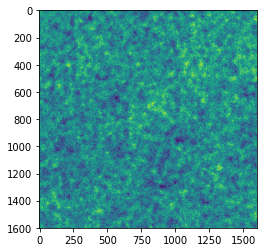

In [5]:
# Let's make this more like a real experiment by convolving with a beam and adding noise

# Beam
beam_arcmin = 1.4
def gauss_beam(ell,fwhm):
    # A gaussian beam transfer function (map-space, i.e. one power)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
# Evaluate the beam on an isotropic Fourier grid
kbeam2d = gauss_beam(modlmap,beam_arcmin)
# Filter the map to convolve it with a beam
beamed = filter_map(lensed,kbeam2d)

# Noise
noise_uk_arcmin = 1.5 # CMB-S4 level white noise
# White noise
Clnoise = (noise_uk_arcmin*np.pi/180./60.)**2.
Dlnoise = Clnoise*ells*(ells+1.)/2./np.pi
# Make a GRF noise map
noise_map = make_CMB_T_map(N,pix_size,ells,Dlnoise)

# The observed map
observed = beamed + noise_map

plt.imshow(observed)
plt.show()

EXERCISE: Compare the power spectrum of the lensed CMB map (no beam, no noise) with the unlensed CMB map (no beam, no noise). Can you clearly see what features lensing induces? If it's too noisy, you could try Monte Carloing multiple realizations and averaging over them?

## Lensing reconstruction

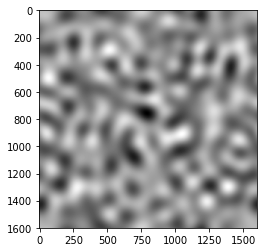

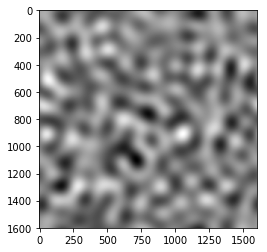

<Figure size 432x288 with 0 Axes>

In [6]:
# Now we attempt to reconstruct a lensing map from the observed map
def qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx):
    """
    The simplest form of the quadratic estimator is

    kappa_recon = - div ( grad(T) T )
    where grad(T) is Wiener filtered with (unlensed_cmb_power/total_cmb_power)
    and T is filtered with (1/total_cmb_power)
    where the T map is beam deconvolved and
    where total_cmb_power = lensed_cmb_power + noise_power / beam^2

    The reconstruction is limited to ellmin < ells < ellmax of the CMB temperature map.

    The grad and div operations require knowledge of:
    modlmap: absolute wavenumbers of Fourier pixels
    ly: map of ly Fourier coordinate of each pixel
    lx: map of lx Fourier coordinate of each pixel
    (note modlmap = sqrt(ly**2 + lx**2)
    """
    inv_noise_filter = kmask((1./total_cmb_power_2d),modlmap,ellmin,ellmax)
    grad_filter = kmask((unlensed_cmb_power_2d/total_cmb_power_2d),modlmap,ellmin,ellmax)

    gradTy,gradTx = gradient(tmap,ly,lx)

    filtered_gradTy = filter_map(gradTy,grad_filter)
    filtered_gradTx = filter_map(gradTx,grad_filter)
    filtered_T = filter_map(tmap,inv_noise_filter)
    
    ukappa = div(filtered_T * filtered_gradTy, filtered_T * filtered_gradTx, ly, lx)

    # We filter with 1/L^2 at the end to make the normalization white
    return -filter_map(ukappa,kmask(1/modlmap**2,modlmap,ellmin=2))

# For this we also need to know how to calculate a divergence
def div(imapy,imapx,ly,lx):
    # Return divergence grad(Y)_y + grad(X)_x
    gy = gradient(imapy,ly,lx)
    gx = gradient(imapx,ly,lx)
    return gy[0] + gx[1]


def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    # Just a simple interpolator that fills with zeros by default
    from scipy.interpolate import interp1d
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)


# To use this we need unlensed and total spectra interpolated on to the 2D Fourier grid
### Prepare 2D Fourier space interpolations of theory spectra
unlensed_cmb_power_2d = interp(ells,ucltt)(modlmap)
total_cmb_power_2d = interp(ells,lcltt)(modlmap) + Clnoise/kbeam2d**2.


### The noise was specified for a beam deconvolved map so we deconvolve the beam from our map
tmap = filter_map(observed,1/kbeam2d)

### Next, we get the unnormalized reconstruction after choosing what multipoles to involve
ellmin = 10
ellmax = 3000
ukappa = qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx)

# Calculating the normalization is a bit involved, so for now we focus on comparing
# the largest scales of the reconstruction with that of the input, where the normalization is
# expected to be somewhat constant

### Filter the reconstruction and the input kappa to the same ellrange (where the normalization
### is expected to be relatively white)
kellmin = 10
kellmax = 100
ukappa_f = filter_map(ukappa,kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))
ikappa_f = filter_map(kappa,kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))

# Plot the filtered maps for comparison
plt.imshow(ukappa_f,cmap='gray')
plt.show()
plt.clf()
plt.imshow(ikappa_f,cmap='gray')
plt.show()
plt.clf()



## Cross power with input

EXERCISE: This looks good by eye! But are we sure it's not just a coincidence? The systematic way of checking that your lensing pipeline is working is to cross-correlate your reconstruction with the input kappa you provided. Calculate the binned 1d cross power and confirm it is non-zero. 

In [1]:
### Calculate binned 1d cross-power between reconstruction and input
ell_max = 1000
delta_ell = 10
